In [1]:
#Packages:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from camera_matrix import camera_matrix
import time
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
def save_BW_img(cap):
    image= []
    while True:
  # Lire l'image suivante de la vidéo
        ret, frame = cap.read()

  # Vérifier si la fin de la vidéo a été atteinte
        if not ret:
            break

  # Convertir l'image en noir et blanc
        img_gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        image.append(img_gray)
    cv2.destroyAllWindows()
    cap.release() 
    return image

In [3]:
# Read a sequence of 2 stereoscopic images, synchronized (frame 107 to 131 for video 1, frame 45 to 69 for video 2)
cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/Design-Project/vid1_dx.MP4")
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010031.MP4")
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010056.MP4")
#cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/Design-Project/vid1_sx.MP4")
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010056.MP4")
cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/Design-Project/vid1_sx.MP4")

dx_images = save_BW_img(cap0)
sx_images = save_BW_img(cap1)


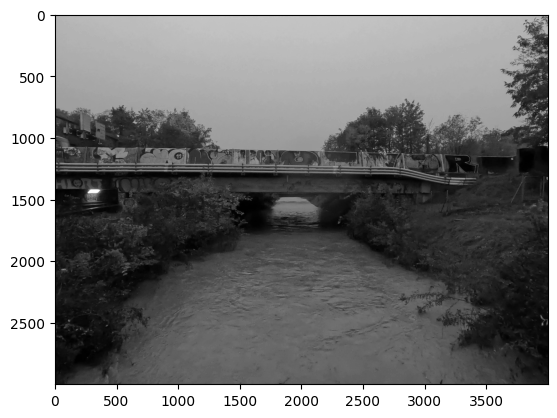

In [4]:
# Show two synchronized images
from PIL import Image
import matplotlib.pyplot as plt

image = dx_images[0]

plt.imshow(image, cmap='gray')

In [5]:
# Define the y-axis range
start_y = 2000
end_y = 2750

# define the x-axis range
start_x = 0
end_x = 4000
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

dx_stripes = []
sx_stripes = []
for dx_img, sx_img in zip(dx_images, sx_images):
    # Convert the image to numpy arrays
    dx_img_array = np.array(dx_img)
    sx_img_array = np.array(sx_img)

    # Select the stripe using array slicing
    dx_selected_stripe = dx_img_array[start_y:end_y, start_x:end_x]
    sx_selected_stripe = sx_img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripes to the respective lists
    dx_stripes.append(dx_selected_stripe)
    sx_stripes.append(sx_selected_stripe)

# Loop through the images and select the stripe for each image
#for img in dx_images:
    # Convert the image to a numpy array
    #img_array = np.array(img)

    # Select the stripe using array slicing
    #selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    #dx_stripes.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image

49


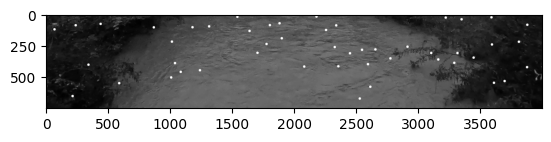

(<matplotlib.image.AxesImage at 0x16a95e040>, None)

In [6]:
nb_points = 7
horizontal_band = 500
def keypoint(nb_points, image):
    keypoints = np.empty((0, 2), dtype=np.intp)
    for i in range (0,image.shape[1]-horizontal_band+1 ,horizontal_band):
        selected_stripe= image[:, i : i + horizontal_band]
        corners = cv2.goodFeaturesToTrack(selected_stripe, nb_points,0.5,70)
        corners = np.intp(corners.reshape(-1, 2))
        corners[:, 0] += i# ajouter i a la coordonnée x 
        keypoints = np.concatenate((keypoints, corners), axis=0)
    return keypoints # les paires de coordonnées de chaque keypoints

corners = keypoint(nb_points, sx_stripes[0])
print(len(corners))
img_circles = dx_stripes[0].copy()

for i in corners:
 x,y = i.ravel()
 cv2.circle(img_circles,(x,y),10,255,-1)
 
plt.imshow(img_circles, cmap='gray'),plt.show()

In [7]:
def NCC_window(x,y, image): # normalized cross correlation window of 9x9 around our pixel of 
    # Do not forget that if x0-4 or x0+5 is out of the image, we will not take into account this tracking point. 
    #NCC = image[y-4:y+5, x-4:x+5] # rows and columns are switched in the image ( image size is 750x1500)
    NCC = image[y-18:y+19, x-18:x+19]
    return NCC

In [8]:
def tracking(x0,y0,image, NCC):
    match = 0
    x1 = 0
    y1 = 0
    for x in range(x0-7, x0+7): 
        for y in range(y0-7, y0+7):
            img_comp = NCC_window(x,y,image)
            res = cv2.matchTemplate(img_comp,NCC, cv2.TM_CCORR_NORMED)
            if np.max(res) > match: 
                match = np.max(res)
                x1 = x
                y1 = y
    return(x1, y1)

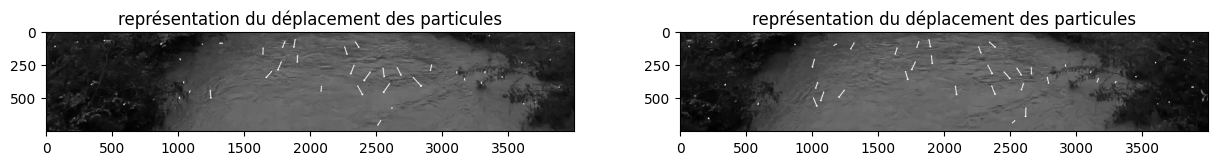

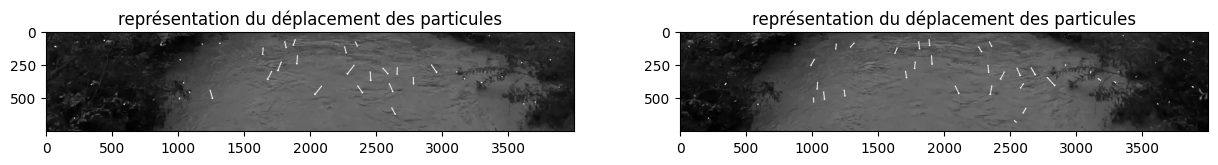

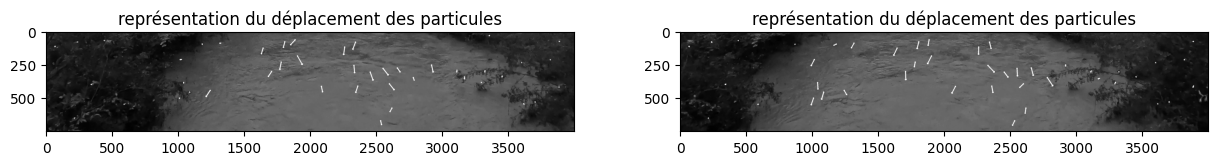

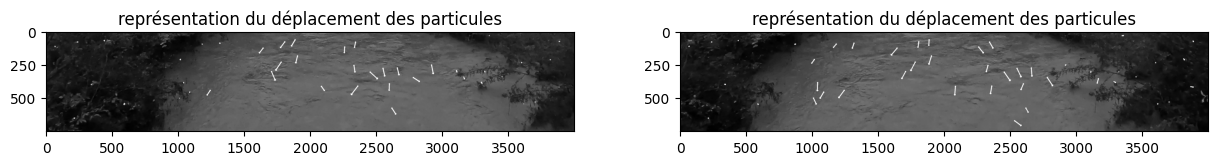

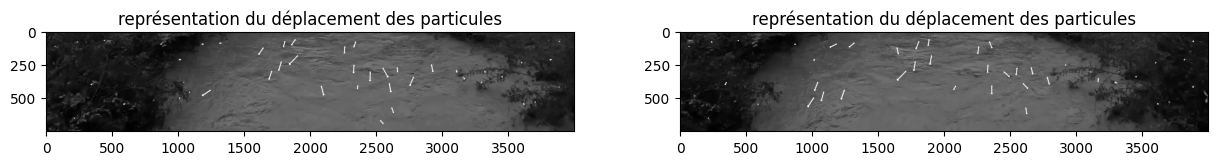

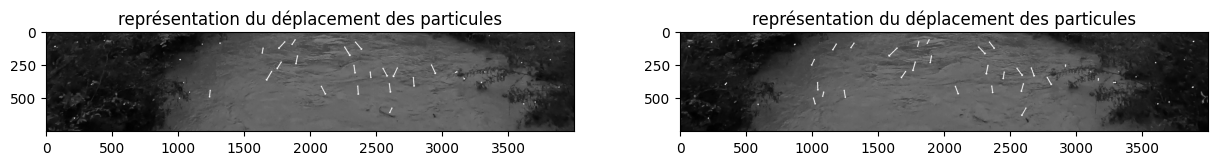

In [13]:
### celui de sub 5

stats = pd.DataFrame()
img_list=[]
for img_nb in range(0, min(len(dx_stripes), len(sx_stripes))):
    if img_nb % 30 == 0 and img_nb + 13 < len(dx_stripes): # la deuxieme condition est nécessaire pour pouvoir analyser les images jusqu'à la fin de la video
        
        corners_dx = keypoint(nb_points, dx_stripes[img_nb])
        coord_track_dx = corners[:,:2].reshape(-1, 2)
        displacement_dx = np.zeros((len(corners),12,2))
        point_i_dx = 0
        point_delete_dx = []

        corners_sx = keypoint(nb_points, sx_stripes[img_nb])
        coord_track_sx = corners[:,:2].reshape(-1, 2)
        displacement_sx = np.zeros((len(corners),12,2))
        point_i_sx = 0
        point_delete_sx = []

        for x,y in coord_track_dx: 
            for i in range(img_nb + 1, img_nb + 13):
                if x< 32 or x > stripe_width-32 or y < 32 or y > stripe_height-32: 
                    #stock les points à enlever
                    point_delete_dx= np.append(point_delete_dx, point_i_dx)
                    break #skip au prochain point
                NCC = NCC_window(x,y, dx_stripes[i-1])
                displacement_dx[point_i_dx, i-1-img_nb ,:]= x,y
                x,y = tracking(x,y, dx_stripes[i], NCC)
            point_i_dx += 1
        point_delete_dx= point_delete_dx.astype(int)
        displacement_dx = np.delete(displacement_dx,point_delete_dx,0 )
        img_circles_dx = dx_stripes[img_nb].copy()

        direction_dx = []
        length_dx = []
        for j in range(displacement_dx.shape[0]):
            x0_dx,y0_dx = displacement_dx[j,0,:]
            x1_dx,y1_dx = displacement_dx[j,11,:]
            # recupere angle et taille des vecteurs

            if y1_dx-y0_dx == 0: #trouver le moyen d'élimier les vecteurs ou on divise par 0
                angle = np.nan
                intensity = np.nan
            else: 
                angle = np.arctan((x1_dx-x0_dx)/(y1_dx-y0_dx))
                intensity = np.sqrt((x1_dx-x0_dx)*(x1_dx-x0_dx) + (y1_dx-y0_dx)*(y1_dx-y0_dx))
            
            direction_dx = np.append(direction_dx, angle)
            length_dx= np.append(length_dx, intensity)

            # représente les vecteurs sur les images
            cv2.circle(img_circles_dx,(int(x0_dx),int(y0_dx)),5,255,-1)
            cv2.circle(img_circles_dx,(int(x1_dx),int(y1_dx)),5,(70,255,212),-1)
            cv2.arrowedLine(img_circles_dx, (int(x0_dx),int(y0_dx)), (int(x1_dx),int(y1_dx)), 255, 6)

        x0_dx = displacement_dx[:, 0, 0]
        y0_dx = displacement_dx[:, 0, 1]
        x1_dx = displacement_dx[:, 11, 0]
        y1_dx = displacement_dx[:, 11, 1]


        for x,y in coord_track_sx: 
            for i in range(img_nb + 1, img_nb + 13):
                if x< 32 or x > stripe_width-32 or y < 32 or y > stripe_height-32: 
                    #stock les points à enlever
                    point_delete_sx= np.append(point_delete_sx, point_i_sx)
                    break #skip au prochain point
                NCC = NCC_window(x,y, sx_stripes[i-1])
                displacement_sx[point_i_sx, i-1-img_nb ,:]= x,y
                x,y = tracking(x,y, sx_stripes[i], NCC)
            point_i_sx += 1
        point_delete_sx= point_delete_sx.astype(int)
        displacement_sx = np.delete(displacement_sx,point_delete_sx,0 )
        img_circles_sx = sx_stripes[img_nb].copy()

        direction_sx = []
        length_sx = []
        for j in range(displacement_sx.shape[0]):
            x0_sx,y0_sx = displacement_sx[j,0,:]
            x1_sx,y1_sx = displacement_sx[j,11,:]
            # recupere angle et taille des vecteurs

            if y1_sx-y0_sx == 0: #trouver le moyen d'élimier les vecteurs ou on divise par 0
                angle = np.nan
                intensity = np.nan
            else: 
                angle = np.arctan((x1_sx-x0_sx)/(y1_sx-y0_sx))
                intensity = np.sqrt((x1_sx-x0_sx)*(x1_sx-x0_sx) + (y1_sx-y0_sx)*(y1_sx-y0_sx))
            
            direction_sx = np.append(direction_sx, angle)
            length_sx= np.append(length_sx, intensity)

            # représente les vecteurs sur les images
            cv2.circle(img_circles_sx,(int(x0_sx),int(y0_sx)),5,255,-1)
            cv2.circle(img_circles_sx,(int(x1_sx),int(y1_sx)),5,(70,255,212),-1)
            cv2.arrowedLine(img_circles_sx, (int(x0_sx),int(y0_sx)), (int(x1_sx),int(y1_sx)), 255, 6)

        x0_sx = displacement_sx[:, 0, 0]
        y0_sx = displacement_sx[:, 0, 1]
        x1_sx = displacement_sx[:, 11, 0]
        y1_sx = displacement_sx[:, 11, 1]

        x0_sx -= 50
        x0_sx[x0_sx < 0] = 0
        x1_sx -= 50
        x1_sx[x0_sx < 0] = 0

        stats_temp = pd.DataFrame({
            'x0': np.concatenate((x0_dx, x0_sx)),
            'y0': np.concatenate((y0_dx, y0_sx)),
            'x1': np.concatenate((x1_dx, x1_sx)),
            'y1': np.concatenate((y1_dx, y1_sx)),
            'direction': np.concatenate((direction_dx, direction_sx)),
            'length': np.concatenate((length_dx, length_sx)),
        })
        stats = pd.concat([stats, stats_temp], ignore_index=True)
        
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        plt.title('représentation du déplacement des particules')
        plt.imshow(img_circles_sx, cmap = 'gray')

        plt.subplot(1, 2, 2)
        plt.title('représentation du déplacement des particules')
        plt.imshow(img_circles_dx, cmap = 'gray'),plt.show()
        img_list.append(img_circles_sx)

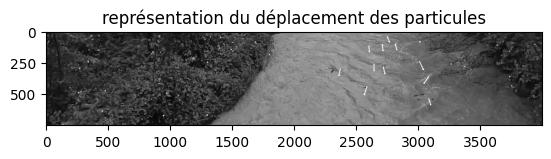

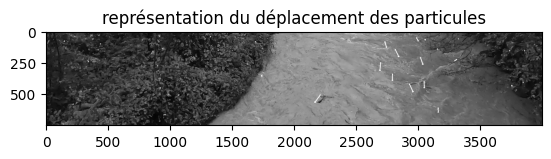

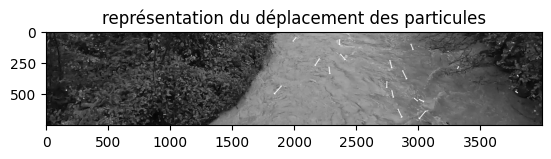

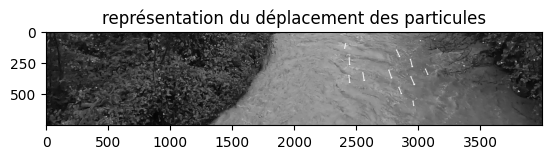

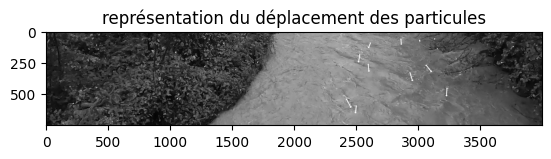

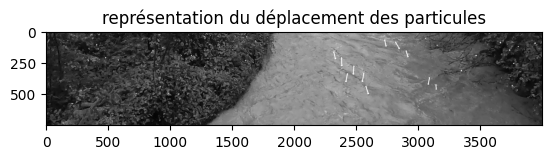

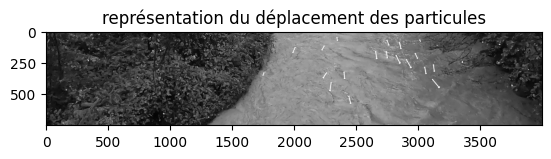

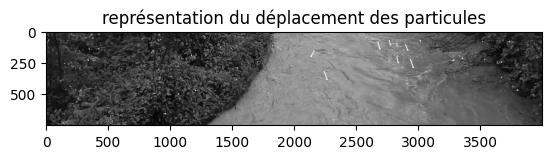

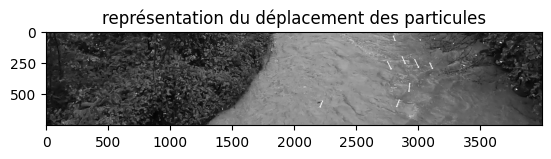

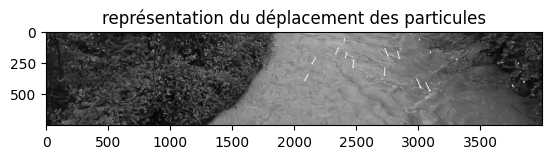

In [12]:
### celui de sub 5

stats = pd.DataFrame()
img_list=[]
for img_nb in range(0, len(dx_stripes)):
    if img_nb % 30 == 0 and img_nb + 13 < len(dx_stripes): # la deuxieme condition est nécessaire pour pouvoir analyser les images jusqu'à la fin de la video
        corners = keypoint(nb_points, dx_stripes[img_nb])
        coord_track = corners[:,:2].reshape(-1, 2)
        displacement = np.zeros((len(corners),12,2))
        point_i = 0
        point_delete = []
        for x,y in coord_track: 
            for i in range(img_nb + 1, img_nb + 13):
                if x< 32 or x > stripe_width-32 or y < 32 or y > stripe_height-32: 
                    #stock les points à enlever
                    point_delete= np.append(point_delete, point_i)
                    break #skip au prochain point
                NCC = NCC_window(x,y, dx_stripes[i-1])
                displacement[point_i, i-1-img_nb ,:]= x,y
                x,y = tracking(x,y, dx_stripes[i], NCC)
            point_i += 1
        point_delete= point_delete.astype(int)
        displacement = np.delete(displacement,point_delete,0 )
        img_circles = dx_stripes[img_nb].copy()

        direction = []
        length = []
        for j in range(displacement.shape[0]):
            x0,y0 = displacement[j,0,:]
            x1,y1 = displacement[j,11,:]
            # recupere angle et taille des vecteurs

            if y1-y0 == 0: #trouver le moyen d'élimier les vecteurs ou on divise par 0
                angle = np.nan
                intensity = np.nan
            else: 
                angle = np.arctan((x1-x0)/(y1-y0))
                intensity = np.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))
            
            direction = np.append(direction, angle)
            length= np.append(length, intensity)

            # représente les vecteurs sur les images
            cv2.circle(img_circles,(int(x0),int(y0)),5,255,-1)
            cv2.circle(img_circles,(int(x1),int(y1)),5,(70,255,212),-1)
            cv2.arrowedLine(img_circles, (int(x0),int(y0)), (int(x1),int(y1)), 255, 6)

        x0 = displacement[:, 0, 0]
        y0 = displacement[:, 0, 1]
        x1 = displacement[:, 11, 0]
        y1 = displacement[:, 11, 1]

        stats_temp = pd.DataFrame({
            'x0': x0,
            'y0': y0,
            'x1': x1,
            'y1': y1,
            'direction': direction,
            'length': length
        })
        stats = pd.concat([stats, stats_temp], ignore_index=True)
        plt.title('représentation du déplacement des particules')
        plt.imshow(img_circles, cmap = 'gray'),plt.show()
        img_list.append(img_circles)

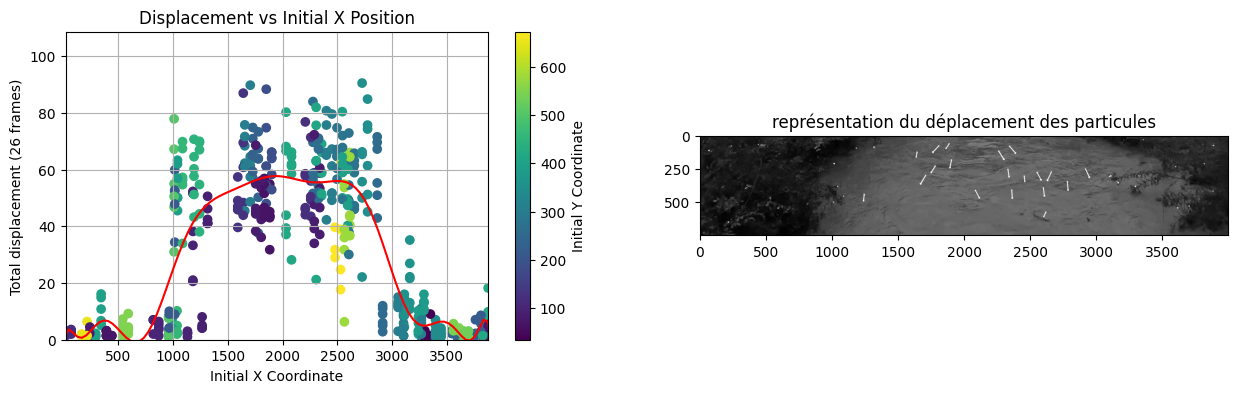

In [14]:
stats = stats.dropna()
x = stats.x0
y = stats.length

mymodel = np.poly1d(np.polyfit(x, y, 14))
myline = np.linspace(5, 4000, 100)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(x, y, c=stats.y0, cmap='viridis')
plt.plot(myline, mymodel(myline), color='red')
#plt.scatter(stats.x0, stats.length)
plt.xlabel("Initial X Coordinate")
plt.ylabel("Total displacement (26 frames)")
plt.title("Displacement vs Initial X Position")
plt.colorbar(label='Initial Y Coordinate')
plt.ylim(bottom=0, top=np.max(y) + 0.2*np.max(y))
plt.xlim(left = np.min(x), right= np.max(x))
plt.grid(True)

# Affichage de la dernière image de img_list
plt.subplot(1, 2, 2)
plt.title('représentation du déplacement des particules')
plt.imshow(img_list[-1], cmap='gray')
plt.show() 

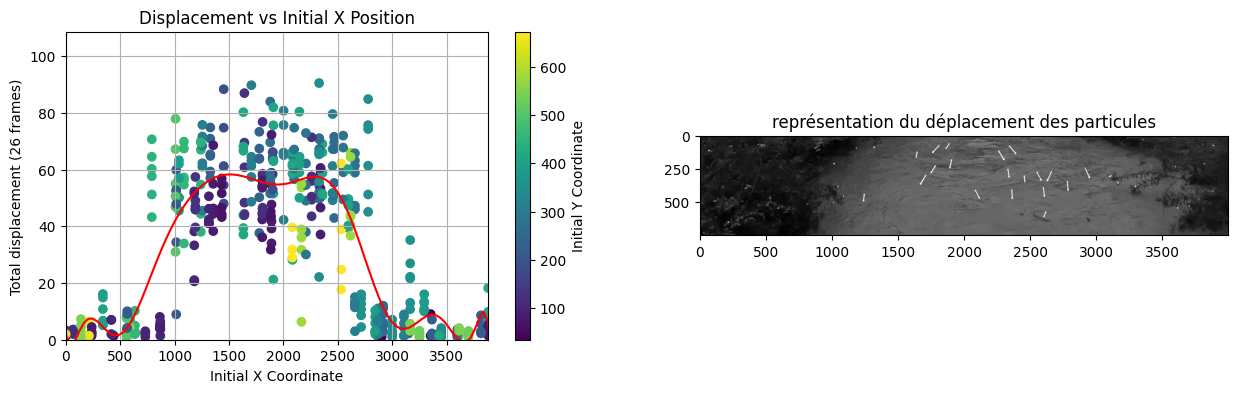

In [10]:
stats = stats.dropna()
x = stats.x0
y = stats.length

mymodel = np.poly1d(np.polyfit(x, y, 14))
myline = np.linspace(5, 4000, 100)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(x, y, c=stats.y0, cmap='viridis')
plt.plot(myline, mymodel(myline), color='red')
#plt.scatter(stats.x0, stats.length)
plt.xlabel("Initial X Coordinate")
plt.ylabel("Total displacement (26 frames)")
plt.title("Displacement vs Initial X Position")
plt.colorbar(label='Initial Y Coordinate')
plt.ylim(bottom=0, top=np.max(y) + 0.2*np.max(y))
plt.xlim(left = np.min(x), right= np.max(x))
plt.grid(True)

# Affichage de la dernière image de img_list
plt.subplot(1, 2, 2)
plt.title('représentation du déplacement des particules')
plt.imshow(img_list[-1], cmap='gray')
plt.show() 

Comment réduire la std? 

    - prendre en compte les jeux de luminosité

    - The distance thresholds canbe roughly approximated when the image scale and the range of expected river ﬂow velocity are known. In this study, the minimum and maximum distance parameters are set to 0.1and 10 pixels, respectively.

    - considers the directional ﬂow behaviour of the feature with a steadiness parameter. Therefore,directions of sub-tracks (from frame to frame) are analysed for each track. Tracks are excluded when the standard devi-ation is above a deﬁned threshold (30° in this study). The idea is that river observations are performed during nearly uniform ﬂow conditions. Thus, high frequencies of changes in ﬂow directions within a track indicate measurement errors and should be ﬁltered. In addition to this steadiness parameter, the range of all sub-track directions is also considered as a measure of the ﬂow behaviour. If the range is above adeﬁned threshold, the track will be excluded (here 120°).

    - prendre les angles par rapport au point de fuite. 

    - moyenene des vitesses transversales == 0

    - prendre des fenetres NCC plus grande (entre 30 et 50 pixels) ?

In [17]:
display(stats[['direction', 'length']].describe()) #cv2.TM_CCOEFF_NORMED

,direction,length
count,463.000000,463.000000
mean,-0.036098,33.744631
std,0.577802,27.002639
min,-1.508378,1.000000
25%,-0.463648,4.182873
50%,0.000000,39.408121
75%,0.376747,58.090032
max,1.405648,90.553851


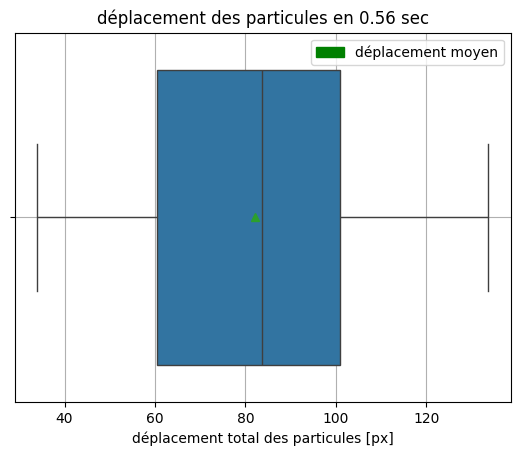

In [13]:
#boxplot= stats.boxplot(column = ['vertical_anlge'])
sns.boxplot(x="length", showmeans=True, data=stats)
#sns.despine(bottom=True)
mean_patch = mpatches.Patch(color='green', label='déplacement moyen')
plt.legend(handles=[mean_patch], loc='upper right')
plt.xlabel("déplacement total des particules [px]")
plt.title("déplacement des particules en 0.56 sec")
plt.grid(True)
plt.show()